<a href="https://colab.research.google.com/github/Karen-Nasambu/Week1ML-project/blob/main/WeekoneML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from datetime import datetime

In [32]:
# Load the CSV (adjust path if needed)
df = pd.read_csv('chip_dataset.csv')  # Or use the uploaded file name

# Preview the data
print(df.head(8))  # First 5 rows


   Unnamed: 0                    Product Type Release Date  Process Size (nm)  \
0           0        AMD Athlon 64 3500+  CPU   2007-02-20               65.0   
1           1           AMD Athlon 200GE  CPU   2018-09-06               14.0   
2           2       Intel Core i5-1145G7  CPU   2020-09-02               10.0   
3           3      Intel Xeon E5-2603 v2  CPU   2013-09-01               22.0   
4           4    AMD Phenom II X4 980 BE  CPU   2011-05-03               45.0   
5           5      Intel Xeon E5-2470 v2  CPU   2013-09-01               22.0   
6           6  AMD Phenom X4 9750 (125W)  CPU   2008-03-27               65.0   
7           7        Intel Pentium D 930  CPU   2006-01-16               65.0   

   TDP (W)  Die Size (mm^2)  Transistors (million)  Freq (MHz)  Foundry  \
0     45.0             77.0                  122.0      2200.0  Unknown   
1     35.0            192.0                 4800.0      3200.0  Unknown   
2     28.0              NaN                  

In [33]:
print(df.info())  # Data types and non-null counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4854 entries, 0 to 4853
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             4854 non-null   int64  
 1   Product                4854 non-null   object 
 2   Type                   4854 non-null   object 
 3   Release Date           4854 non-null   object 
 4   Process Size (nm)      4845 non-null   float64
 5   TDP (W)                4228 non-null   float64
 6   Die Size (mm^2)        4139 non-null   float64
 7   Transistors (million)  4143 non-null   float64
 8   Freq (MHz)             4854 non-null   float64
 9   Foundry                4854 non-null   object 
 10  Vendor                 4854 non-null   object 
 11  FP16 GFLOPS            536 non-null    float64
 12  FP32 GFLOPS            1948 non-null   float64
 13  FP64 GFLOPS            1306 non-null   float64
dtypes: float64(8), int64(1), object(5)
memory usage: 531.0+ 

In [34]:
print(df.describe())  # Summary stats for numerical columns

        Unnamed: 0  Process Size (nm)      TDP (W)  Die Size (mm^2)  \
count  4854.000000        4845.000000  4228.000000      4139.000000   
mean   2426.500000          55.109598    81.359981       188.440445   
std    1401.373433          44.998676    76.807808       126.189383   
min       0.000000           0.000000     1.000000         1.000000   
25%    1213.250000          22.000000    33.000000       104.000000   
50%    2426.500000          40.000000    65.000000       148.000000   
75%    3639.750000          90.000000   100.000000       239.000000   
max    4853.000000         250.000000   900.000000       826.000000   

       Transistors (million)   Freq (MHz)    FP16 GFLOPS   FP32 GFLOPS  \
count            4143.000000  4854.000000     536.000000   1948.000000   
mean             1929.922279  1484.406057    8397.459851   2134.756653   
std              4044.891098  1066.701523   13799.551131   3898.431487   
min                 8.000000   100.000000      10.020000     12.

## Explore Missingness

In [35]:
# Separate categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

In [36]:
# Missing values count and percentage
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0])  # Show only columns with missing data

                       Missing Count  Missing %
Process Size (nm)                  9   0.185414
TDP (W)                          626  12.896580
Die Size (mm^2)                  715  14.730119
Transistors (million)            711  14.647713
FP16 GFLOPS                     4318  88.957561
FP32 GFLOPS                     2906  59.868150
FP64 GFLOPS                     3548  73.094355


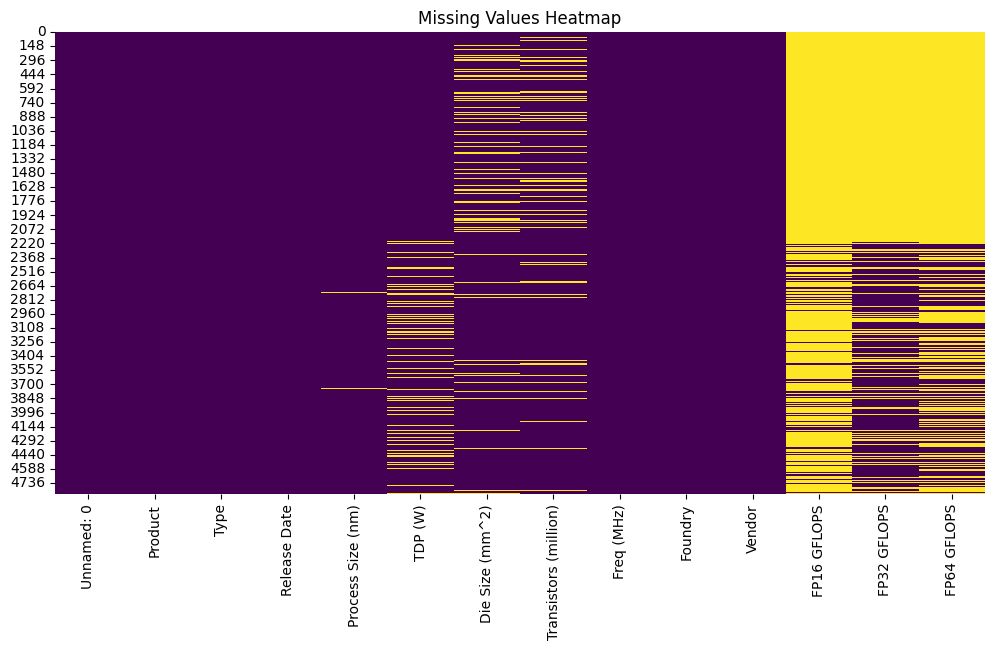

In [37]:
# Visualize missingness
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [38]:
# For categorical: value counts for missing-prone cols (e.g., Foundry, Vendor)
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        print(f"\n{col} unique values: {df[col].unique()}")

## Handle Missing Values

Rationale:
Deletion: For rows with >50% missing (rare, but drop if critical data like 'Type' is missing). Avoid over-deletion to preserve data.
Imputation: For numerical (e.g., mean/median for 'Process Size (nm)', 'TDP (W)' – median if skewed). For categorical (e.g., mode for 'Foundry'/'Vendor' if 'Unknown' is common, or fill with 'Unknown').
Temporal: For 'Release Date', forward-fill or impute based on similar products (but we'll handle in Step 5).
Domain-specific: Performance metrics (GFLOPS) are often missing for older CPUs – impute with group means (grouped by 'Type'/'Vendor') to avoid bias. Don't impute if >70% missing (drop column instead).

In [39]:
# Drop rows with missing 'Type' (critical for CPU/GPU classification)
df = df.dropna(subset=['Type'])
print(df.head(4))

   Unnamed: 0                Product Type Release Date  Process Size (nm)  \
0           0    AMD Athlon 64 3500+  CPU   2007-02-20               65.0   
1           1       AMD Athlon 200GE  CPU   2018-09-06               14.0   
2           2   Intel Core i5-1145G7  CPU   2020-09-02               10.0   
3           3  Intel Xeon E5-2603 v2  CPU   2013-09-01               22.0   

   TDP (W)  Die Size (mm^2)  Transistors (million)  Freq (MHz)  Foundry  \
0     45.0             77.0                  122.0      2200.0  Unknown   
1     35.0            192.0                 4800.0      3200.0  Unknown   
2     28.0              NaN                    NaN      2600.0    Intel   
3     80.0            160.0                 1400.0      1800.0    Intel   

  Vendor  FP16 GFLOPS  FP32 GFLOPS  FP64 GFLOPS  
0    AMD          NaN          NaN          NaN  
1    AMD          NaN          NaN          NaN  
2  Intel          NaN          NaN          NaN  
3  Intel          NaN          NaN    

In [40]:
# Impute numerical with median (robust to outliers) Use median instead of mean for numerical features when the data is skewed or has outliers
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)
print(df.head(20))


    Unnamed: 0                    Product Type Release Date  \
0            0        AMD Athlon 64 3500+  CPU   2007-02-20   
1            1           AMD Athlon 200GE  CPU   2018-09-06   
2            2       Intel Core i5-1145G7  CPU   2020-09-02   
3            3      Intel Xeon E5-2603 v2  CPU   2013-09-01   
4            4    AMD Phenom II X4 980 BE  CPU   2011-05-03   
5            5      Intel Xeon E5-2470 v2  CPU   2013-09-01   
6            6  AMD Phenom X4 9750 (125W)  CPU   2008-03-27   
7            7        Intel Pentium D 930  CPU   2006-01-16   
8            8       Intel Core i3-1125G4  CPU   2020-09-02   
9            9     AMD Athlon 64 X2 4200+  CPU   2006-05-23   
10          10          AMD Sempron 2800+  CPU   2004-08-01   
11          11       Intel Core i7-3632QM  CPU   2012-10-19   
12          12                   AMD C-70  CPU   2012-09-01   
13          13        Intel Core i5-8269U  CPU   2018-04-05   
14          14      AMD Phenom X4 9600 BE  CPU   2007-1

/tmp/ipython-input-4293915625.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [41]:
# Impute categorical with mode or 'Unknown'
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        if col == 'Foundry' or col == 'Vendor':
            df[col].fillna('Unknown', inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

In [42]:
# Group-impute for performance metrics (e.g., FP32 GFLOPS by Type/Vendor)
df['FP32 GFLOPS'] = df.groupby(['Type', 'Vendor'])['FP32 GFLOPS'].transform(lambda x: x.fillna(x.median()))
# Repeat for other GFLOPS if needed

# Check missing again
print(df.isnull().sum())

Unnamed: 0               0
Product                  0
Type                     0
Release Date             0
Process Size (nm)        0
TDP (W)                  0
Die Size (mm^2)          0
Transistors (million)    0
Freq (MHz)               0
Foundry                  0
Vendor                   0
FP16 GFLOPS              0
FP32 GFLOPS              0
FP64 GFLOPS              0
dtype: int64


In [48]:
print(df['Type'].value_counts(normalize=True))

Type
GPU    0.551147
CPU    0.448853
Name: proportion, dtype: float64


Rationale Details: Median for numerical avoids outlier influence (e.g., transistors vary hugely). Group imputation preserves trends (e.g., GPUs have higher GFLOPS). 'Unknown' for Foundry/Vendor is explicit in data.

## Drop Non-Consequential Fields

Non-consequential: Unnamed index, 'Product' (too unique, not useful for ML patterns), any duplicates.

### How to identify Non-consequential fields

You ask yourself these 7 questions in order. If the answer to any one is “yes”, you drop the column with confidence.

Question (Ask in this order)If YES → Drop itReal example from your chip dataset1Is it a unique identifier or name? (almost no repeated values)YESProduct (e.g., “Ryzen 9 7950X”, “GeForce RTX 4090”) → every row is unique2Is it a direct leak of the target? (contains the answer)YESType after you already created Type_encoded → keep only the encoded version3Is it constant or near-constant? (>98–99% same value)YESA column that is “2024” in 99.9% rows, or “Made in Taiwan” everywhere4Is it a random ID, index, row number, timestamp with no pattern?YESUnnamed: 0, index, scrape_timestamp, record_id5Is it 100% missing or >90–95% missing with no reliable way to impute?YESA column with 4830/4854 missing values and no pattern → just noise6Is it perfectly correlated (100%) with another column? (duplicate information)YESDie Size (mm^2) and Die_Size_mm2_exact_copy → keep only one7Does it have extremely high cardinality with no clear ordering or business meaning?UsuallyProduct again (4840 unique values) → one-hot encoding would create 4840 columns → disaster


In [43]:
## Code for identifying the non sequential data

def find_non_consequential_columns(df, target_col=None):
    drop_candidates = []

    for col in df.columns:
        if col == target_col:
            continue

        # 1. Unique identifier?
        unique_ratio = df[col].nunique() / len(df)
        if unique_ratio > 0.99:  # >99% unique values
            print(f"High cardinality ID → {col} ({df[col].nunique()} unique)")
            drop_candidates.append(col)
            continue

        # 2. Constant column?
        if df[col].nunique() <= 1:
            print(f"Constant → {col}")
            drop_candidates.append(col)
            continue

        # 3. >95% missing?
        if df[col].isnull().mean() > 0.95:
            print(f"Too many missing → {col} ({df[col].isnull().mean():.1%})")
            drop_candidates.append(col)
            continue

        # 4. Perfect duplicate of another column?
        for other_col in df.columns:
            if col != other_col and df[col].equals(df[other_col]):
                print(f"Duplicate → {col} == {other_col}")
                drop_candidates.append(col)

    return drop_candidates

# Run it
candidates = find_non_consequential_columns(df)
print("\nRecommended to drop:", candidates)

print(df.shape)

High cardinality ID → Unnamed: 0 (4854 unique)

Recommended to drop: ['Unnamed: 0']
(4854, 14)


In [44]:
# Drop unnamed index and non-useful cols
df = df.drop(columns=['Unnamed: 0', 'Product'], errors='ignore')  # 'Unnamed: 0' if present

# Check for duplicates and drop
df = df.drop_duplicates()
print(df.shape)  # New shape

(4184, 12)


## Transform Temporal Data

Release Date' is object/string or NaT – convert to datetime. Temporaldata is data that has to do with time

In [45]:
# Convert to datetime (handle NaT/errors)
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')

# Impute missing dates with median date (or drop if many missing)
median_date = df['Release Date'].median()
df['Release Date'].fillna(median_date, inplace=True)

# Extract features: year, month for ML
df['Year'] = df['Release Date'].dt.year
df['Month'] = df['Release Date'].dt.month
df['Day'] = df['Release Date'].dt.day
print(df[['Release Date', 'Year', 'Month', 'Day']].head())

  Release Date  Year  Month  Day
0   2007-02-20  2007      2   20
1   2018-09-06  2018      9    6
2   2020-09-02  2020      9    2
3   2013-09-01  2013      9    1
4   2011-05-03  2011      5    3


/tmp/ipython-input-287167799.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Release Date'].fillna(median_date, inplace=True)


## Full EDA and Validate Assumptions

EDA is Exploratory Data Analysis. This is where analysts investigate datasets to uncover patterns, spot anomalies, test hypotheses, and summarize main characteristics, often using data visualization. It helps to understand underlying structures ofthe data, identify issues and choose the best modeling techniques by making the data more comprehensible

Perform EDA: distributions, trends, visualizations. Validate each assumption with code/plots.

The Universal 10-Step EDA Framework







































































StepWhat you doCode (copy-paste)What you learn1Look at the raw data (first & last rows)df.head(10)
df.tail(5)
df.sample(5)Spot obvious garbage, weird formatting2Shape & basic infoprint(df.shape)
df.info()How many rows/columns, memory, data types3Missing values heatmap + %```sns4Target distribution (your “y”)df['Type'].value_counts(dropna=False, normalize=True)
sns.countplot(data=df, x='Type')Is it balanced? 50/50 CPU/GPU or 90/10?5Numerical summary (mean, median, outliers)df.describe(include='all')Spot impossible values (negative TDP, 5000 nm process)6Distribution of every numerical columnimport matplotlib.pyplot as plt\nimport seaborn as sns\ncols = df.select_dtypes(include='number').columns\nfor col in cols:\n    plt.figure(figsize=(8,4))\n    sns.histplot(df[col].dropna(), kde=True)\n    plt.title(col)\n    plt.show()Skewed? Outliers? Log-transform needed?7Categorical columns breakdowncat_cols = df.select_dtypes(include='object').columns\nfor col in cat_cols:\n    print(f"\n{col}:")\n    print(df[col].value_counts(dropna=False).head(10))High cardinality? Typos? Rare categories?8Correlation matrix (only numerical)plt.figure(figsize=(12,8))\nsns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', center=0)\nplt.title("Correlation Matrix")\nplt.show()Multicollinearity → drop one of two perfectly correlated columns9Key business plots (the “money plots”)Examples for chips:
sns.scatterplot(data=df, x='Year', y='Transistors (million)', hue='Type')
sns.boxplot(data=df, x='Type', y='FP32 GFLOPS')
sns.lineplot(data=df, x='Year', y='Process Size (nm)', hue='Foundry')See Moore’s Law, CPU vs GPU gaps, TSMC vs Intel trends10Outliers detection (the 1.5×IQR rule or z-score)```def count_outliers(col):\n    Q1 = col.quantile(0.25)\n    Q3 = col.quantile(0.75)\n    IQR = Q3 - Q1\n    return ((col < (Q1 - 1.5 * IQR))

How to know WHEN you’re done with EDA
You can stop when you can confidently answer these 10 questions:

What is my target and is it balanced?
Which columns have >50% missing → drop?
Which columns are unique IDs or constants → drop?
Which numerical columns are skewed → median + maybe log?
Which categorical columns need encoding?
Are there strong trends over time (Year)?
Are CPU and GPU clearly separable on some plots?
Are there impossible/outlier values (e.g., TDP = 9999)?
Which features are highly correlated (can drop one)?
Do I understand the business story (Moore’s Law, process shrink, etc.)?

In [46]:
### The 2-minute “cheat sheet” version of EDA
print("Shape:", df.shape)
print("\nMissing %")
print((df.isnull().sum() / len(df) * 100).sort_values(ascending=False))

print("\nDuplicates:", df.duplicated().sum())
print("\nTarget distribution")
print(df['Type'].value_counts(normalize=True))

df.describe(include='all')

Shape: (4184, 15)

Missing %
Type                     0.0
Release Date             0.0
Process Size (nm)        0.0
TDP (W)                  0.0
Die Size (mm^2)          0.0
Transistors (million)    0.0
Freq (MHz)               0.0
Foundry                  0.0
Vendor                   0.0
FP16 GFLOPS              0.0
FP32 GFLOPS              0.0
FP64 GFLOPS              0.0
Year                     0.0
Month                    0.0
Day                      0.0
dtype: float64

Duplicates: 0

Target distribution
Type
GPU    0.551147
CPU    0.448853
Name: proportion, dtype: float64


,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS,Year,Month,Day
count,4184,4184,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184,4184,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,10,5,NaN,NaN,NaN,NaN,NaN,NaN
top,GPU,NaN,NaN,NaN,NaN,NaN,NaN,TSMC,AMD,NaN,NaN,NaN,NaN,NaN,NaN
freq,2306,NaN,NaN,NaN,NaN,NaN,NaN,1902,1431,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2011-06-04 01:37:03.326959872,53.089627,79.841778,185.950765,1812.417782,1496.777725,NaN,NaN,3612.489608,1328.164493,163.773448,2010.981358,5.936424,12.206501
min,NaN,2000-01-01 00:00:00,0.000000,1.000000,1.000000,8.000000,100.000000,NaN,NaN,10.020000,12.800000,3.600000,2000.000000,1.000000,1.000000
25%,NaN,2007-04-17 00:00:00,22.000000,35.000000,116.000000,222.000000,600.000000,NaN,NaN,2965.500000,696.000000,89.280000,2007.000000,3.000000,3.000000
50%,NaN,2011-06-14 00:00:00,40.000000,65.000000,148.000000,624.000000,1086.000000,NaN,NaN,2965.500000,696.000000,89.280000,2011.000000,6.000000,11.000000
75%,NaN,2015-05-05 00:00:00,80.000000,95.000000,228.000000,1400.000000,2400.000000,NaN,NaN,2965.500000,696.000000,89.280000,2015.000000,9.000000,21.000000
max,NaN,2021-04-13 00:00:00,250.000000,900.000000,826.000000,54200.000000,4700.000000,NaN,NaN,184600.000000,40000.000000,11540.000000,2021.000000,12.000000,31.000000


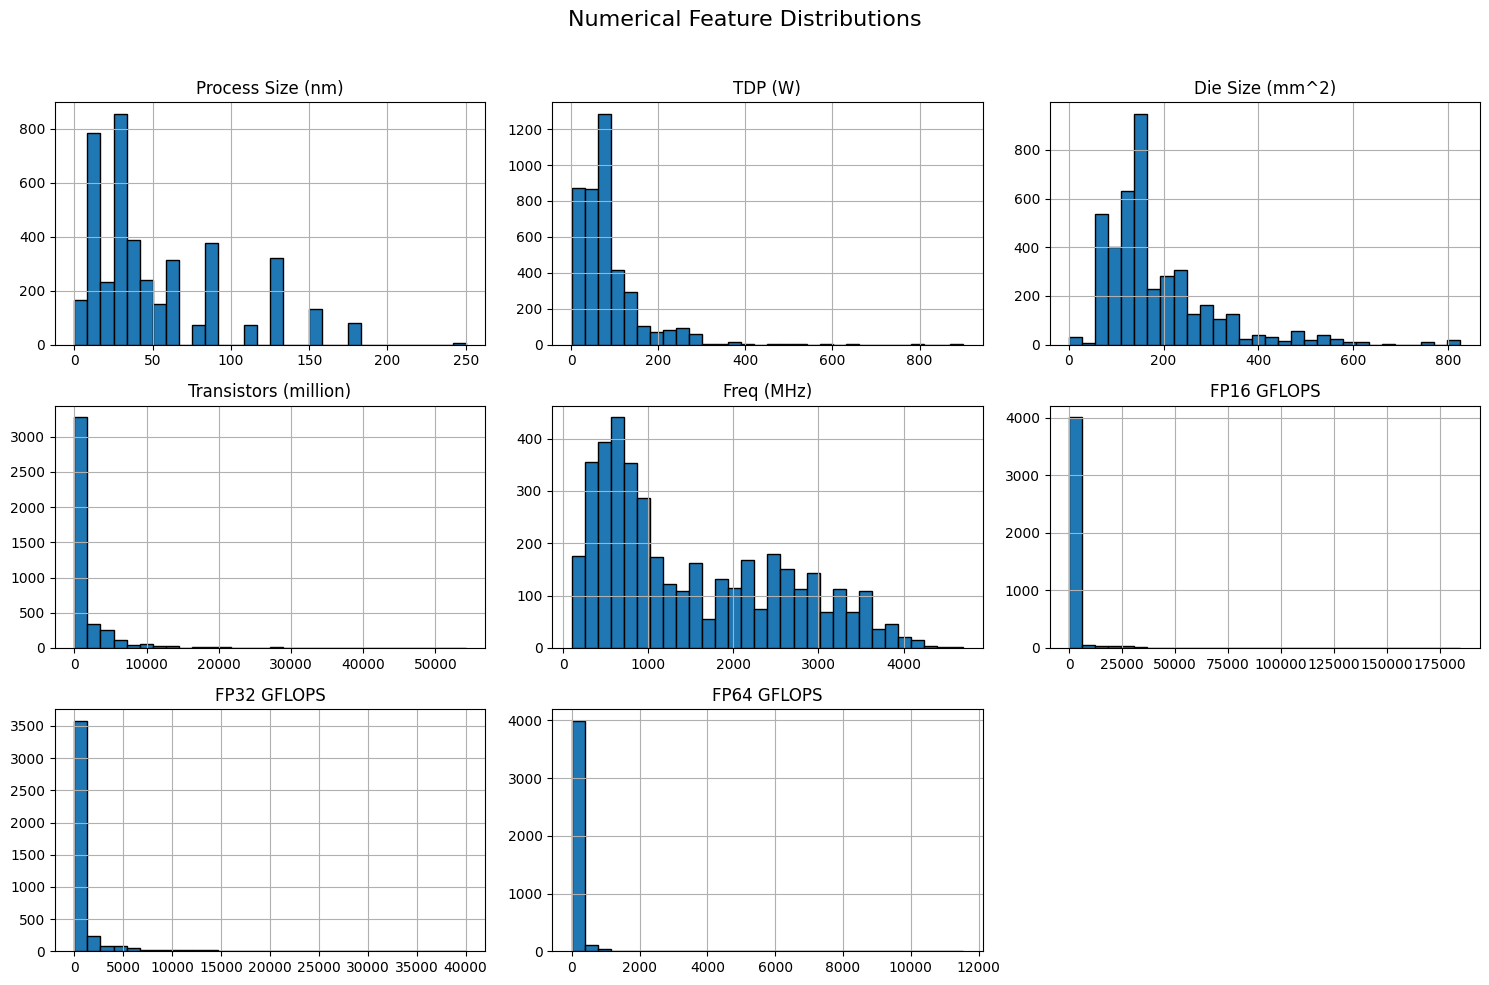

In [50]:
# Re-define numerical columns automatically (safe, always up-to-date)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Now plot — will never give KeyError again
df[numerical_cols].hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Numerical Feature Distributions', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])   # makes title fit nicely
plt.show()

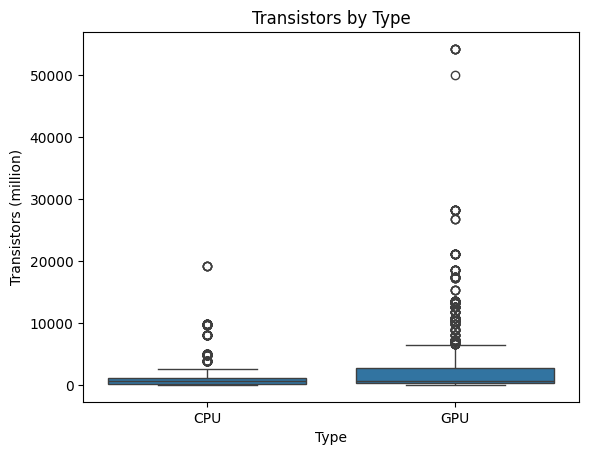

In [51]:
# Boxplots for outliers (e.g., by Type)
sns.boxplot(x='Type', y='Transistors (million)', data=df)
plt.title('Transistors by Type')
plt.show()

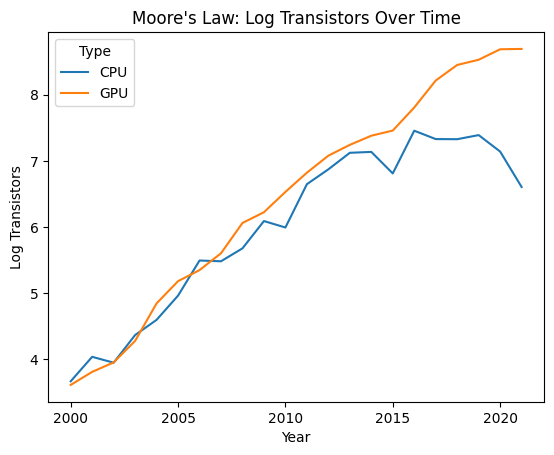

In [52]:
# Assumption 1: Moore's Law (transistors double every ~2 years, esp. GPUs)
# Plot log(transistors) vs year
df['Log Transistors'] = np.log(df['Transistors (million)'] + 1)  # Log for exponential
sns.lineplot(x='Year', y='Log Transistors', hue='Type', data=df.groupby(['Year', 'Type'])['Log Transistors'].mean().reset_index())
plt.title('Moore\'s Law: Log Transistors Over Time')
plt.show()
# Validation: If GPU line slopes up ~0.35/year (doubling every 2 yrs), it holds.

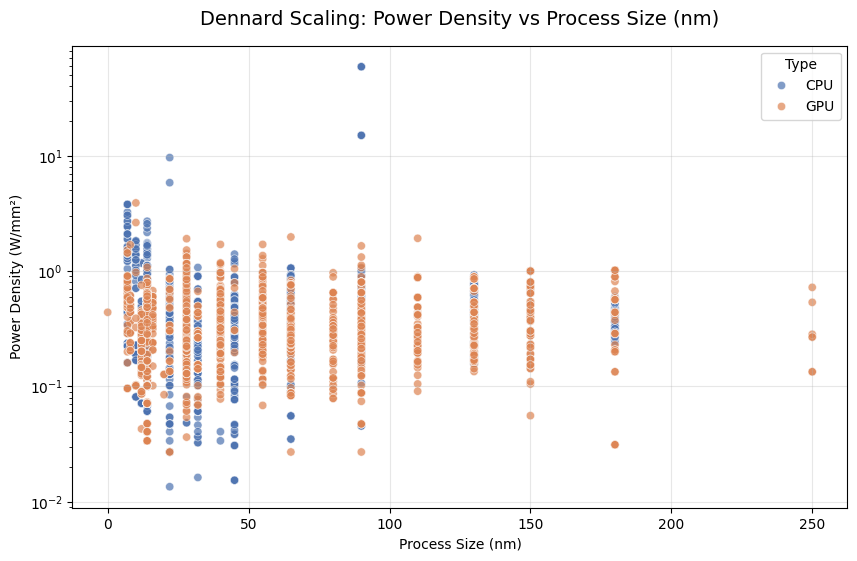

In [55]:
# Assumption 2: Dennard Scaling (power density should stay roughly constant)
# Power Density = TDP (W) / Die Size (mm²)

# Step 1: Create the column safely (avoid division by zero or missing values)
df['Power Density (W/mm²)'] = df['TDP (W)'] / df['Die Size (mm^2)']

# Step 2: Plot it correctly (you had backslashes instead of new lines)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Process Size (nm)',
    y='Power Density (W/mm²)',
    hue='Type',
    alpha=0.7,
    palette='deep'
)
plt.title('Dennard Scaling: Power Density vs Process Size (nm)', fontsize=14, pad=15)
plt.xlabel('Process Size (nm)')
plt.ylabel('Power Density (W/mm²)')
plt.legend(title='Type')
plt.grid(True, alpha=0.3)

# Optional: log scale on Y-axis because power density has huge range
plt.yscale('log')
plt.show()

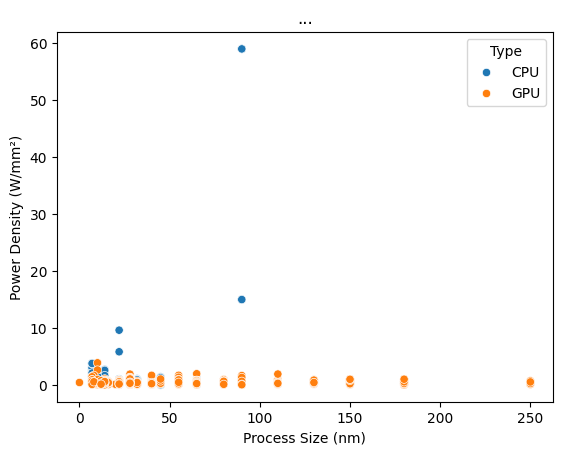

In [56]:
sns.scatterplot( ## Other option
    x='Process Size (nm)',
    y='Power Density (W/mm²)',
    hue='Type',
    data=df
)
plt.title('...')
plt.show()

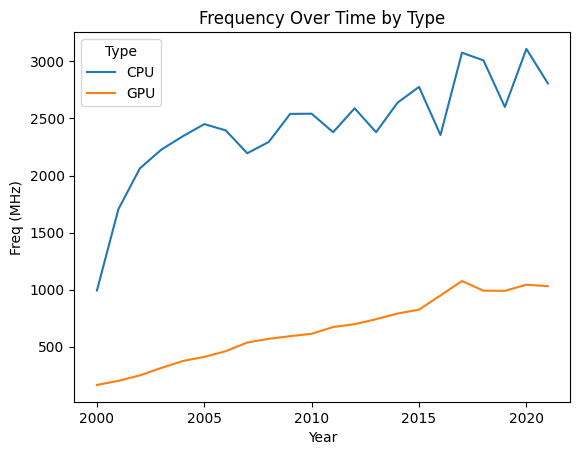

In [57]:
# Assumption 3: CPUs higher freq, GPUs catching up
sns.lineplot(x='Year', y='Freq (MHz)', hue='Type', data=df.groupby(['Year', 'Type'])['Freq (MHz)'].mean().reset_index())
plt.title('Frequency Over Time by Type')
plt.show()
# Validation: CPU line higher, but GPU approaching.

/tmp/ipython-input-2725666814.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpus['Log Perf'] = np.log(gpus['FP32 GFLOPS'] + 1)


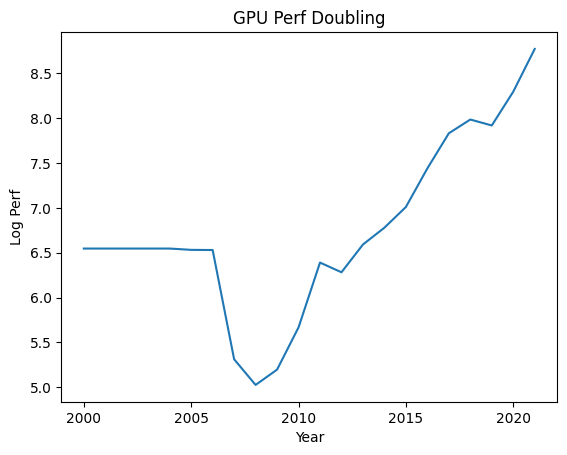

In [58]:
# Assumption 4: GPU perf doubles every 1.5 yrs (use FP32 GFLOPS)
gpus = df[df['Type'] == 'GPU']
gpus['Log Perf'] = np.log(gpus['FP32 GFLOPS'] + 1)
sns.lineplot(x='Year', y='Log Perf', data=gpus.groupby('Year')['Log Perf'].mean().reset_index())
plt.title('GPU Perf Doubling')
plt.show()
# Validation: Slope ~0.46/year (doubling every ~1.5 yrs).

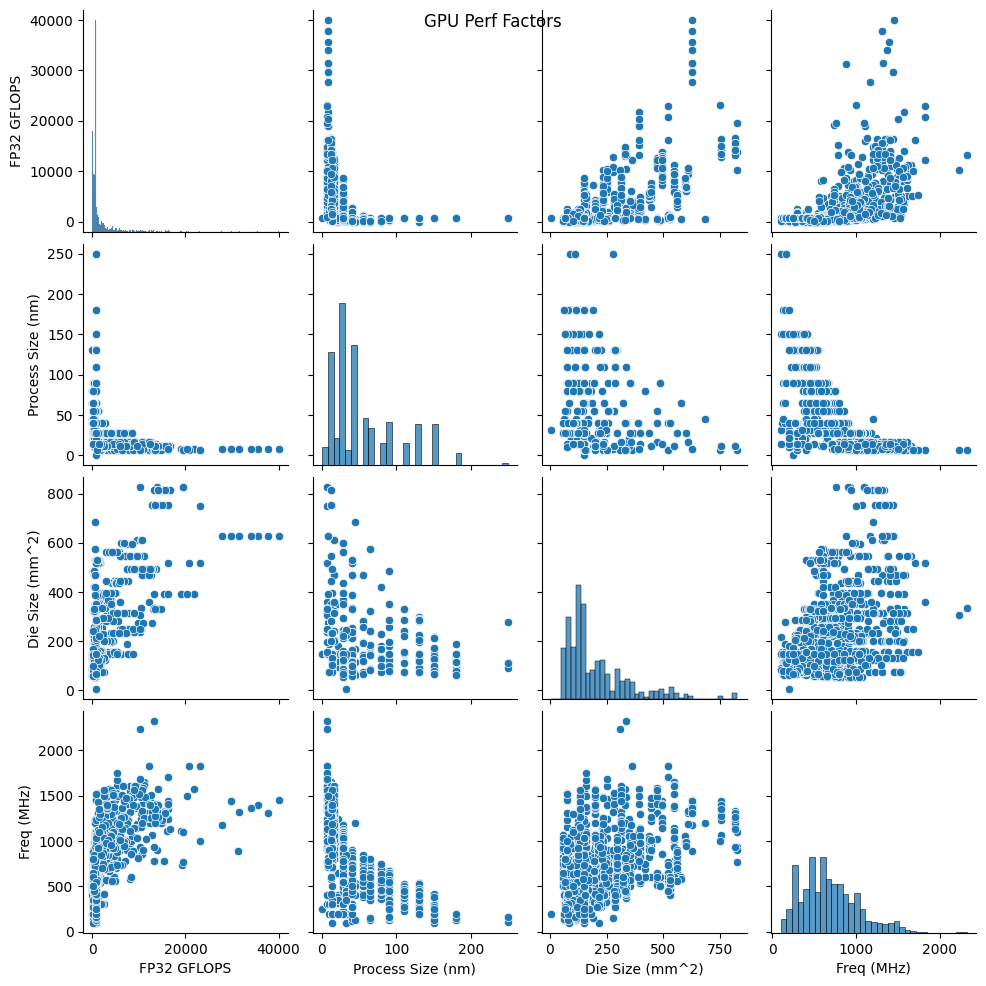

In [59]:
# Assumption 5: GPU perf from smaller transistors, larger die, higher freq
# Correlation/Regression (see Step 8), or scatter
sns.pairplot(gpus[['FP32 GFLOPS', 'Process Size (nm)', 'Die Size (mm^2)', 'Freq (MHz)']])
plt.suptitle('GPU Perf Factors')
plt.show()
# Validation: Negative corr with process size, positive with die/freq.

In [60]:
# Assumption 6: High-end GPUs use new tech first
# Group by Vendor/Process Size, sort by min Year
tech_adopt = df.groupby(['Vendor', 'Process Size (nm)'])['Year'].min().reset_index().sort_values('Year')
print(tech_adopt.head(10))  # Early adopters
# Validation: Nvidia/AMD often first for small nm.

    Vendor  Process Size (nm)  Year
13     AMD              180.0  2000
14     ATI               40.0  2000
23     ATI              180.0  2000
60   Other              250.0  2000
48  NVIDIA              150.0  2000
49  NVIDIA              180.0  2000
33   Intel              180.0  2000
32   Intel              150.0  2000
50  NVIDIA              250.0  2000
58   Other              150.0  2001


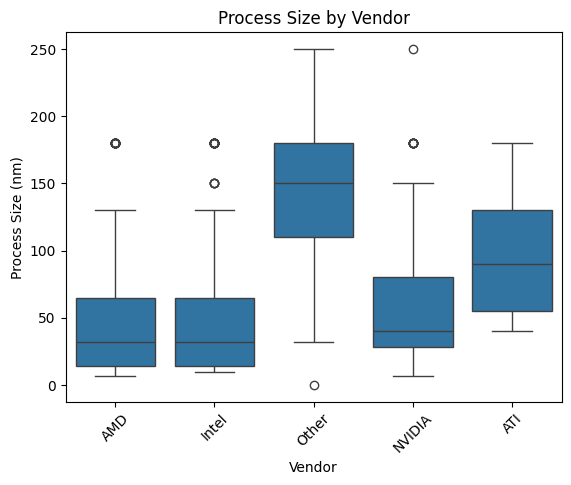

In [61]:
# Assumption 7: Intel/AMD/Nvidia lower process size than ATI/others
sns.boxplot(x='Vendor', y='Process Size (nm)', data=df)
plt.title('Process Size by Vendor')
plt.xticks(rotation=45)
plt.show()
# Validation: Intel/AMD/Nvidia boxes lower.

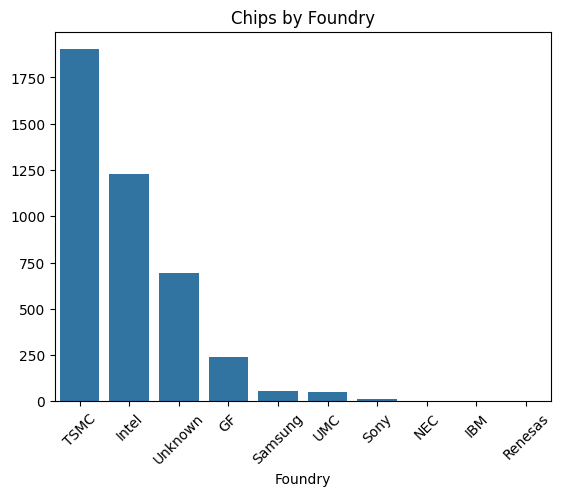

In [62]:
# Assumption 8: TSMC highest chip count
foundry_counts = df['Foundry'].value_counts()
sns.barplot(x=foundry_counts.index, y=foundry_counts.values)
plt.title('Chips by Foundry')
plt.xticks(rotation=45)
plt.show()
# Validation: TSMC bar highest.

## Correlation Among Features
Correlation Identifies and quantify the relationship between variable.

Correlation tells you which features are saying the same thing → so you can remove redundancy, speed up training, and build simpler + better models.
Run the heatmap once → you instantly know 50% of your feature engineering plan.

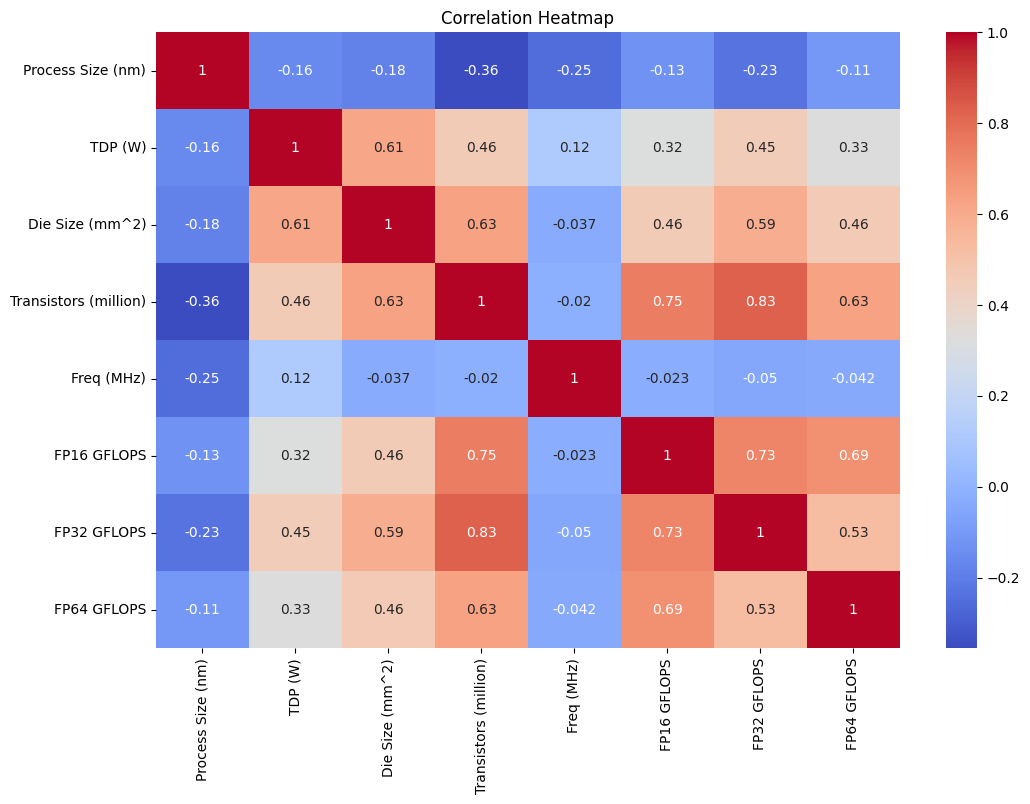

In [63]:
# Numerical correlation matrix
corr = df[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Insights: High corr between transistors/die size (Moore's), perf metrics.

## Encoding for ML
Prepare for modeling: Encode categorical, scale numerical.

In [64]:
# Label encode binary (e.g., Type: CPU=0, GPU=1)
le = LabelEncoder()
df['Type_encoded'] = le.fit_transform(df['Type'])

# One-hot encode multi-class (Vendor, Foundry)
df = pd.get_dummies(df, columns=['Vendor', 'Foundry'], drop_first=True)

# Scale numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print(df.head())  # Ready for ML

  Type Release Date  Process Size (nm)   TDP (W)  Die Size (mm^2)  \
0  CPU   2007-02-20           0.273933 -0.479518        -0.921686   
1  CPU   2018-09-06          -0.899045 -0.617146         0.051174   
2  CPU   2020-09-02          -0.991043 -0.713485        -0.321050   
3  CPU   2013-09-01          -0.715048  0.002178        -0.219534   
4  CPU   2011-05-03          -0.186058  0.621501         0.609511   

   Transistors (million)  Freq (MHz)  FP16 GFLOPS  FP32 GFLOPS  FP64 GFLOPS  \
0              -0.449083    0.659574    -0.126705    -0.235069    -0.123233   
1               0.793692    1.597504    -0.126705    -0.235069    -0.123233   
2              -0.315719    1.034746    -0.126705    -0.235069    -0.123233   
3              -0.109564    0.284401    -0.126705    -0.235069    -0.123233   
4              -0.280121    2.066470    -0.126705    -0.235069    -0.123233   

   ...  Vendor_Other  Foundry_IBM  Foundry_Intel  Foundry_NEC  \
0  ...         False        False          Fa

RF Accuracy: 0.998805256869773
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       411
           1       1.00      1.00      1.00       426

    accuracy                           1.00       837
   macro avg       1.00      1.00      1.00       837
weighted avg       1.00      1.00      1.00       837



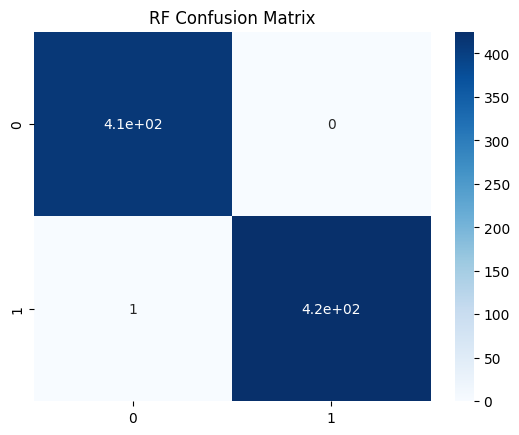

LR Accuracy: 0.994026284348865
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       411
           1       0.99      1.00      0.99       426

    accuracy                           0.99       837
   macro avg       0.99      0.99      0.99       837
weighted avg       0.99      0.99      0.99       837



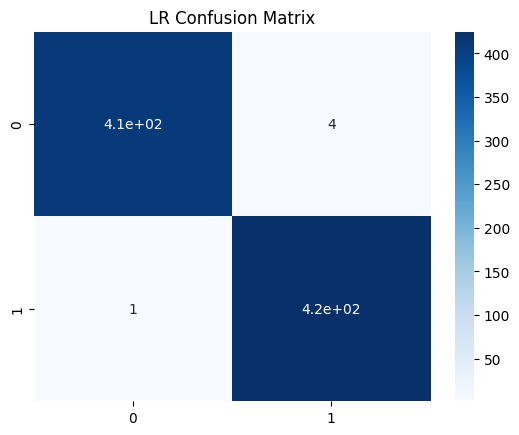

In [65]:
# Split data
X = df.drop(['Type', 'Type_encoded', 'Release Date'], axis=1)  # Drop non-features
y = df['Type_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print('RF Accuracy:', accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, cmap='Blues')
plt.title('RF Confusion Matrix')
plt.show()

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print('LR Accuracy:', accuracy_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred))
sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, cmap='Blues')
plt.title('LR Confusion Matrix')
plt.show()

Comparison: RF often outperforms LR on non-linear data (higher accuracy). Tune hyperparameters if needed (e.g., GridSearchCV).

This prepares your data end-to-end. If the full dataset differs, adjust column names.

In [66]:
# Save to your current Colab session folder (temporary but downloadable)
df.to_csv('chip_dataset_cleaned.csv', index=False)